In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import yaml

from evolution.evaluation.evaluator import EnROADSEvaluator
from evolution.utils import process_config
from experiments.experiment_utils import NNExperimenter, DirectExperimenter
from enroadspy import load_input_specs
from enroadspy.generate_url import open_browser

In [2]:
results_dir = Path("results/app")
with open(results_dir / "config.yml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

config = process_config(config)

print(config)

gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
outcome_keys = list(outcomes.keys())
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes, len(actions), len(context))

{'actions': [1, 2, 3, 211, 197, 196, 202, 203, 4, 7, 8, 9, 212, 199, 198, 204, 205, 10, 11, 12, 213, 201, 200, 206, 207, 16, 17, 18, 311, 23, 24, 25, 313, 314, 292, 293, 294, 30, 31, 32, 39, 40, 41, 42, 43, 44, 312, 298, 263, 264, 265, 414, 267, 266, 268, 245, 247, 248, 249, 45, 46], 'batch_size': 64, 'context': [235, 64, 236, 63], 'decomplexify': True, 'device': 'mps', 'evolution_params': {'mutation_factor': 0.1, 'mutation_rate': 0.1, 'n_elites': 10, 'n_generations': 100, 'population_size': 100, 'remove_population_pct': 0.8, 'save_path': 'results/app', 'seed_dir': 'evolution/seeding/seeds/app'}, 'model_params': [{'in_features': 4, 'out_features': 64, 'type': 'linear'}, {'type': 'tanh'}, {'in_features': 64, 'out_features': 61, 'type': 'linear'}, {'type': 'sigmoid'}], 'n_jobs': -1, 'outcomes': {'Government net revenue below zero': True, 'Max cost of energy': True, 'Temperature change from 1850': True, 'Total energy below baseline': True}}
99 {'Government net revenue below zero': True, '

In [3]:
input_specs = load_input_specs()

evaluator = EnROADSEvaluator(context, actions, outcomes, n_jobs=1, batch_size=config["batch_size"], device=config["device"])
if len(context) > 0:
    experimenter = NNExperimenter(results_dir)
else:
    experimenter = DirectExperimenter(results_dir)

make: `enroads' is up to date.
make: `enroads' is up to date.
make: `enroads' is up to date.
make: `enroads' is up to date.


In [4]:
def get_search_space_size(actions: list[str]):
    input_specs = load_input_specs()
    size = 1
    for action in actions:
        row = input_specs[input_specs["id"] == action].iloc[0]
        if row["kind"] == "switch":
            size *= 2
        elif row["kind"] == "slider":
            combs = int((row["maxValue"] - row["minValue"]) / row["step"])
            size *= combs
    
    size = int(size)
    return size

size = get_search_space_size(actions)
n_atoms = 1e82
print(f"{size:.2e}")
f"{size / n_atoms:.2e}"

1.72e+96


'1.72e+14'

In [5]:
baseline_actions = {}
baseline_df = evaluator.enroads_runner.evaluate_actions(baseline_actions)
baseline_metrics = evaluator.outcome_manager.process_outcomes(baseline_actions, baseline_df)
for outcome in outcomes:
    print(f"{outcome}: {baseline_metrics[outcome]}")

Government net revenue below zero: 0
Max cost of energy: 24.9071
Temperature change from 1850: 3.32279
Total energy below baseline: -0.0


In [6]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
final_pareto

,cand_id,parents,cv,rank,distance,Temperature change from 1850,Max cost of energy,Government net revenue below zero,Total energy below baseline
0,30_3,"['28_41', '27_65']",0,1,inf,2.004638,48.10444,0.000000,17407.4368
1,73_6,"['69_18', '69_18']",0,1,inf,2.825800,21.89870,226.169030,19.0868
2,90_72,"['88_25', '89_24']",0,1,inf,2.936302,21.89870,29.142859,603.4242
3,91_4,"['89_9', '89_9']",0,1,inf,1.945216,75.94730,165.313055,15829.6484
4,98_32,"['96_64', '73_6']",0,1,inf,2.837616,21.89870,219.024010,17.1806
...,...,...,...,...,...,...,...,...,...
60,99_35,"['90_22', '30_3']",0,1,0.030898,2.105146,37.32562,0.000000,17196.0184
61,99_9,"['91_4', '91_4']",0,1,0.023733,1.947230,75.70104,164.664696,15845.8288
62,99_1,"['30_3', '96_81']",0,1,0.023641,1.992480,52.86860,0.000000,17156.7600
63,99_88,"['30_3', '30_3']",0,1,0.014121,2.005894,48.09004,0.000000,17425.0412


In [7]:
context_input, context_vals = evaluator.context_dataset[0]

In [8]:
def evenly_sample(lst, m):
    middle = lst[1:-1]
    step = len(middle) / (m-2)
    sample = [middle[int(i * step)] for i in range(m-2)]
    sample = [lst[0]] + sample + [lst[-1]]
    return sample

In [9]:
if len(final_pareto) < 10:
    sample_points = final_pareto["cand_id"].tolist()
else:
    outcome_sort = outcome_keys[1]
    sample_points = final_pareto.sort_values(outcome_sort, ascending=outcomes[outcome_sort])["cand_id"].tolist()
    sample_points = evenly_sample(sample_points, 9)

    # sample_pareto = final_pareto[final_pareto["Temperature change from 1850"] <= 1.5].sort_values("Cost change year", ascending=False)
    # sample_points = evenly_sample(sample_pareto["cand_id"].tolist(), 9)
    # sample_pareto

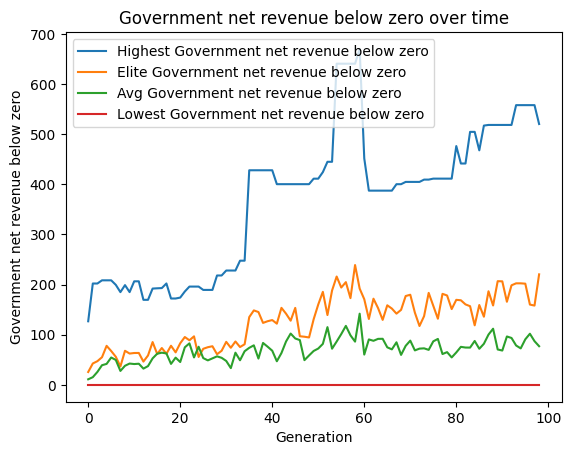

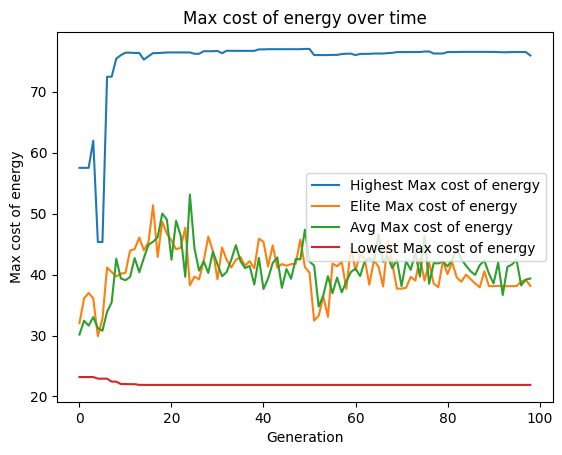

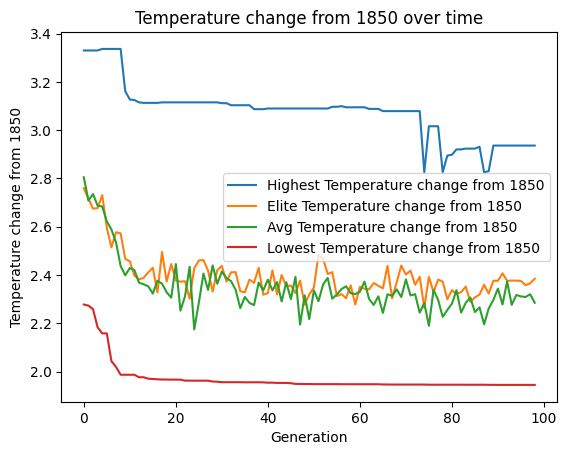

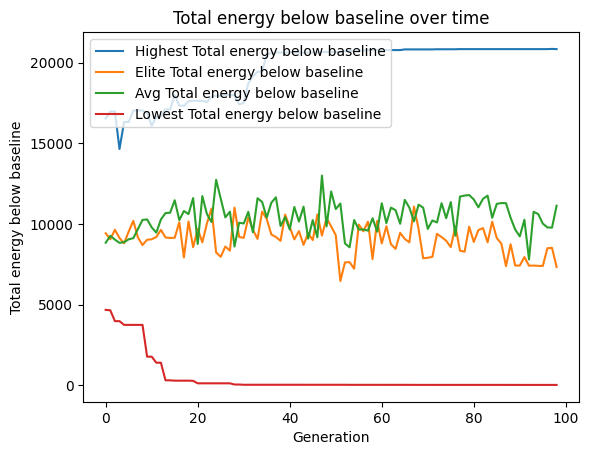

In [10]:
def plot_objective_over_time(outcome):
    best = []
    worst = []
    avg = []
    elite = []
    for gen in range(1, gens+1):
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        pareto = gen_df[gen_df["rank"] == 1]
        scores = pareto.sort_values("distance", ascending=False)[outcome]
        best.append(scores.max())
        worst.append(scores.min())
        avg.append(scores.mean())
        elite.append(scores.iloc[:n_elites].mean())
    
    # plt.plot(range(gens), [baseline_df[outcome].iloc[-1] for _ in range(gens)], label=f"Baseline {outcome}", color="black")

    plt.plot(range(gens), best, label=f"Highest {outcome}")
    plt.plot(range(gens), elite, label=f"Elite {outcome}")
    plt.plot(range(gens), avg, label=f"Avg {outcome}")
    plt.plot(range(gens), worst, label=f"Lowest {outcome}")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel(outcome)
    plt.title(f"{outcome} over time")
    plt.show()

for outcome in outcomes:
    plot_objective_over_time(outcome)

In [11]:
def plot_two_objective(outcome1, outcome2, gens, pareto=True):

    gen_dfs = []
    for gen in gens:
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        gen_df = gen_df[gen_df["rank"] == 1] if pareto else gen_df
        gen_df["color"] = gen
        gen_dfs.append(gen_df)
    
    total_gen_df = pd.concat(gen_dfs)
    cmap = "viridis_r" if len(gens) != 1 else "viridis"
    fig, ax = plt.subplots()
    scatter = ax.scatter(total_gen_df[outcome1], total_gen_df[outcome2], c=total_gen_df["color"], cmap=cmap)

    title = f"{outcome1} vs {outcome2} Final Pareto"

    if len(gens) != 1:
        cbar = fig.colorbar(scatter)
        cbar.set_label("Generation", rotation=270, labelpad=15)
        title = f"{outcome1} vs {outcome2} over Evolution"
    
    ax.set_title(title)

    ax.set_ylabel(outcome2)
    ax.set_xlabel(outcome1)
    plt.show()

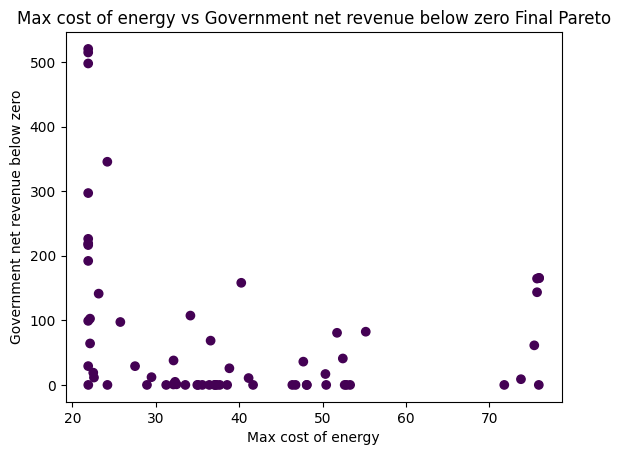

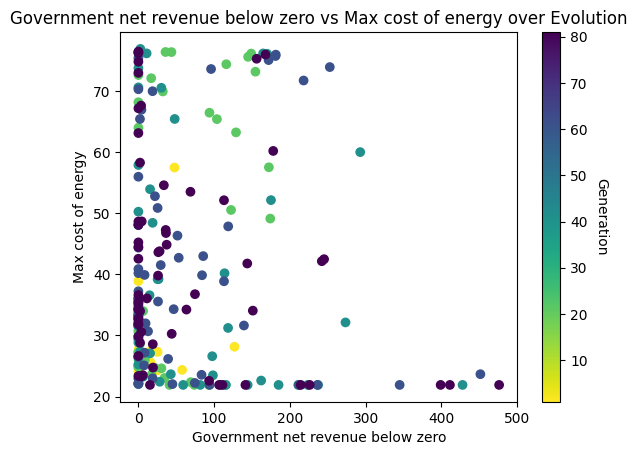

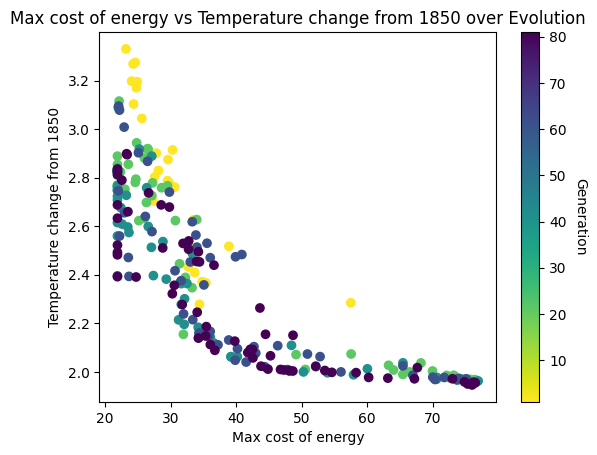

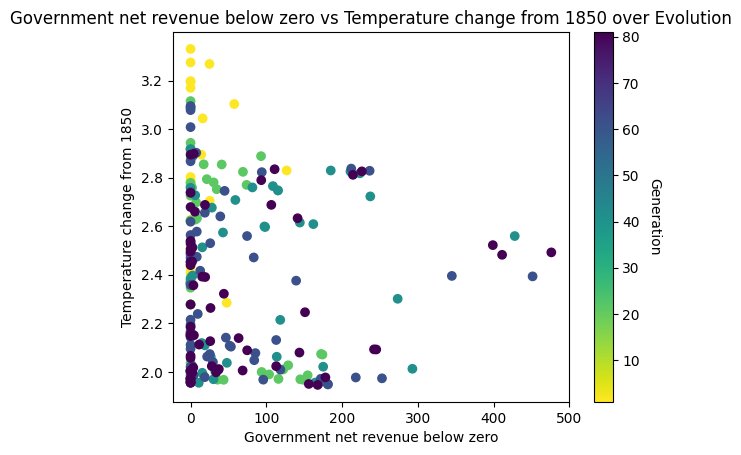

In [12]:
plot_two_objective(outcome_keys[1], outcome_keys[0], [gens])
plot_two_objective(outcome_keys[0], outcome_keys[1], range(1, gens+1, 20))
plot_two_objective(outcome_keys[1], outcome_keys[2], range(1, gens+1, 20))
plot_two_objective(outcome_keys[0], outcome_keys[2], range(1, gens+1, 20))

In [13]:
best_cand_ids = []
for outcome, ascending in outcomes.items():
    best_cand_ids.append(final_pareto.sort_values(outcome, ascending=ascending).iloc[0]["cand_id"])
    print(final_pareto.sort_values(outcome, ascending=ascending).iloc[0][outcome_keys])
    print()
best_cand_ids = list(set(best_cand_ids))
best_cand_ids

Government net revenue below zero           0.0
Max cost of energy                     48.10444
Temperature change from 1850           2.004638
Total energy below baseline          17407.4368
Name: 0, dtype: object

Government net revenue below zero    99.182296
Max cost of energy                     21.8987
Temperature change from 1850           2.81811
Total energy below baseline          1669.9006
Name: 57, dtype: object

Government net revenue below zero    165.73586
Max cost of energy                    75.93856
Temperature change from 1850          1.945106
Total energy below baseline          15855.941
Name: 6, dtype: object

Government net revenue below zero    219.02401
Max cost of energy                     21.8987
Temperature change from 1850          2.837616
Total energy below baseline            17.1806
Name: 4, dtype: object



['99_70', '98_32', '30_3', '99_53']

   cand_id             parents  cv  rank  distance  \
3     91_4    ['89_9', '89_9']   0     1       inf   
7    99_85  ['98_80', '98_80']   0     1       inf   
18   99_72    ['73_6', '73_6']   0     1  0.181206   
21   99_65  ['98_10', '98_32']   0     1  0.164625   
41   99_58   ['73_6', '98_80']   0     1  0.079205   
53   99_40  ['98_46', '90_72']   0     1  0.049799   
54   99_20   ['98_81', '98_7']   0     1  0.048287   
57   99_53  ['90_72', '98_77']   0     1  0.044645   
60   99_35   ['90_22', '30_3']   0     1  0.030898   

    Temperature change from 1850  Max cost of energy  \
3                       1.945216            75.94730   
7                       2.007032            47.68416   
18                      2.814896            21.89870   
21                      2.367086            27.51400   
41                      2.231840            33.54312   
53                      2.732936            21.90944   
54                      2.008216            53.29478   
57         

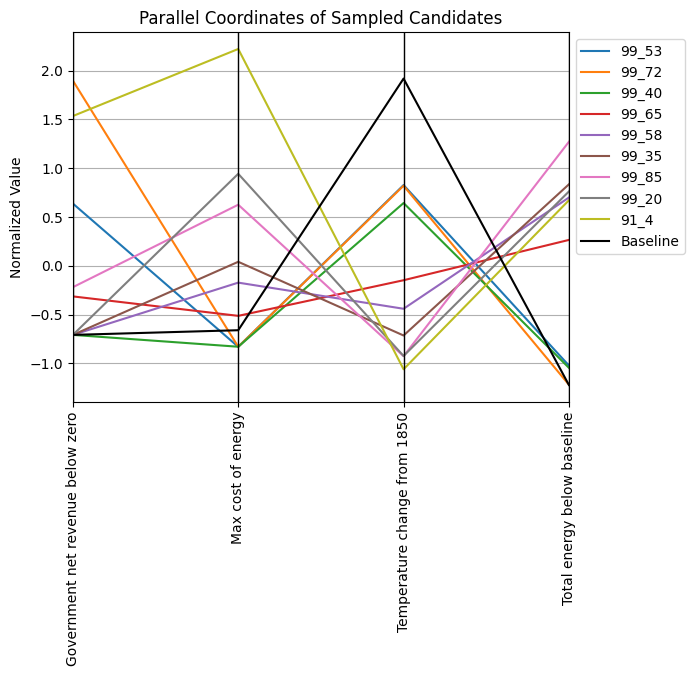

In [14]:
def plot_parallel_coordinates(cand_ids):
    coords_dicts = []
    for cand_id in cand_ids:
        gen = int(cand_id.split("_")[0])
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        row = gen_df[gen_df["cand_id"] == cand_id].iloc[0]
        cand_coords = [row[outcome] for outcome in outcomes]
        cand_dict = dict(zip(outcomes.keys(), cand_coords))
        cand_dict["cand_id"] = cand_id
        coords_dicts.append(cand_dict)

    baseline_dict = {outcome: metric for outcome, metric in baseline_metrics.items()}
    baseline_dict["cand_id"] = "Baseline"
    coords_dicts.append(baseline_dict)

    coords_df = pd.DataFrame(coords_dicts)
    normalized_df = coords_df[outcomes.keys()]
    normalized_df = (normalized_df - normalized_df.mean()) / (normalized_df.std() + 1e-10)
    normalized_df["cand_id"] = coords_df["cand_id"]
    
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Color baseline black
    colors[len(coords_df)-1] = "black" 
    pd.plotting.parallel_coordinates(normalized_df, "cand_id", color=colors)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.ylabel("Normalized Value")
    plt.title("Parallel Coordinates of Sampled Candidates")

plot_parallel_coordinates(sample_points)
print(final_pareto[final_pareto["cand_id"].isin(sample_points)])

In [15]:
def get_average_df(dfs: list[pd.DataFrame]):
    avg_df = dfs[0].copy()
    for df in dfs[1:]:
        avg_df += df
    avg_df /= len(dfs)
    return avg_df

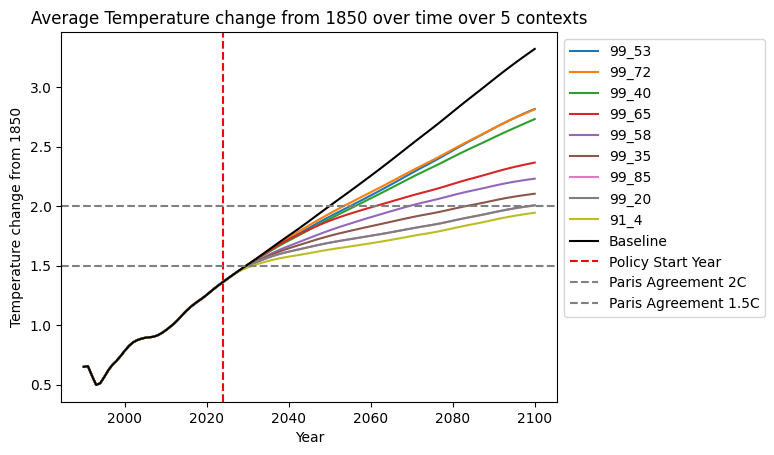

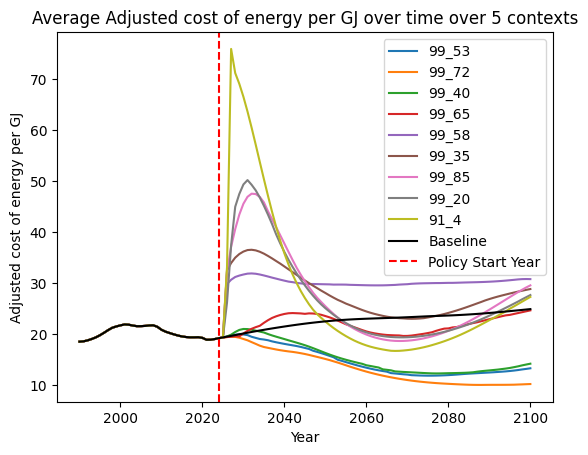

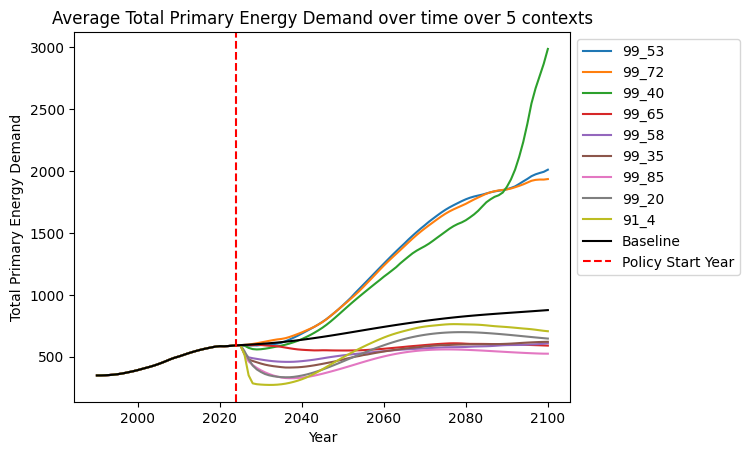

In [16]:
def plot_outcome_over_time(outcome, cand_ids, paris=False):
    for cand_id in cand_ids:
        _, cand_outcomes, _ = experimenter.get_candidate_results(cand_id)
        avg_df = get_average_df(cand_outcomes)
        plt.plot(range(1990, 2101), avg_df[outcome], label=f"{cand_id}")
    plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
    plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")

    if outcome == "CO2 Equivalent Net Emissions":
        plt.axhline(y=0, color="gray", linestyle="--")
        if paris:
            plt.axhline(y=54.4789*0.55, color="orange", linestyle="--", label="Paris Agreement 45% Reduction")
            plt.axvline(x=2035, color="orange", linestyle="--")
            plt.axvline(x=2050, color="gray", linestyle="--", label="Paris Agreement Net Zero")

    elif outcome == "Temperature change from 1850":
        plt.axhline(y=2, color="gray", linestyle="--", label="Paris Agreement 2C")
        plt.axhline(y=1.5, color="gray", linestyle="--", label="Paris Agreement 1.5C")

    plt.legend(bbox_to_anchor=(1, 1))
    if len(cand_outcomes) > 1:
        plt.title(f"Average {outcome} over time over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"{outcome} over time")
    plt.xlabel("Year")
    plt.ylabel(outcome)
    plt.show()

paris = "Emissions Above Paris Agreement" in outcomes
enroads_outcomes = ["Temperature change from 1850", "Adjusted cost of energy per GJ", "Total Primary Energy Demand"]
for outcome in enroads_outcomes:
    plot_outcome_over_time(outcome, sample_points, paris)

In [17]:
def plot_energy_usage(cand_ids):
    fig, axes = plt.subplots(1, len(cand_ids), sharey=True, figsize=(7.5 * len(cand_ids), 5))
    if len(cand_ids) == 1:
        axes = [axes]
    axes[0].set_ylabel("Energy (Exajoules / year)")
    for cand_id, ax in zip(cand_ids, axes):
        cand_outcomes = None
        if cand_id == "baseline":
            cand_outcomes = baseline_df
        else:
            _, cand_outcomes, _ = experimenter.get_candidate_results(cand_id)
            cand_outcomes = get_average_df(cand_outcomes)
        colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
        energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
        demands = [
            "Primary Energy Demand of coal",
            "Primary Energy Demand of oil",
            "Primary Energy Demand of gas",
            "Primary Energy Demand of renew and hydro",
            "Primary Energy Demand of bio",
            "Primary energy demand of nuclear",  # NOTE: There is weird capitalization here so we have to match it
            "Primary energy demand of new tech",
        ]

        energy_df = cand_outcomes[demands]
        for i, demand in enumerate(demands):
            base = 0
            if i != 0:
                for j in range(i):
                    base += energy_df[demands[j]]
            if energy_df[demand].sum() == 0:
                continue
            ax.fill_between(range(1990, 2101), base, base + energy_df[demand], label=energies[i], color=colors[i], alpha=0.8)
        if cand_id != "baseline" and len(outcomes) > 1:
            ax.set_title(f"Average Energy Usage for Candidate {cand_id}")
        else:
            ax.set_title(f"Energy Usage for {cand_id}")
        ax.set_xlabel("Year")
        ax.axvline(x=2024, color="red", linestyle="--")

    plt.suptitle("Global Sources of Primary Energy")
    # Reverse the legend order
    plt.legend(reversed(ax.get_legend_handles_labels()[0]), reversed(ax.get_legend_handles_labels()[1]))
    plt.show()

In [18]:
def plot_energy_difference(cand_id):
    colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
    energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
    demands = [
        "Primary Energy Demand of coal",
        "Primary Energy Demand of oil",
        "Primary Energy Demand of gas",
        "Primary Energy Demand of renew and hydro",
        "Primary Energy Demand of bio",
        "Primary energy demand of nuclear",  # NOTE: There is weird capitalization here so we have to match it
        "Primary energy demand of new tech",
    ]

    _, cand_outcomes, _ = experimenter.get_candidate_results(cand_id)
    avg_outcomes = get_average_df(cand_outcomes)
    energy_df = avg_outcomes[demands]

    energy_baseline = baseline_df[demands]

    diff_df = energy_df - energy_baseline
    plt.grid(axis="y")
    plt.bar(energies, diff_df.iloc[-1], color=colors)
    plt.ylabel("Difference in Energy (Exajoules / year)")
    plt.xlabel("Energy Source")
    if len(cand_outcomes) > 1:
        plt.title(f"Average Difference in Energy from Baseline for {cand_id} in 2100 over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"Difference in Energy from Baseline for {cand_id} in 2100")
    plt.xticks(rotation=90)
    plt.show()

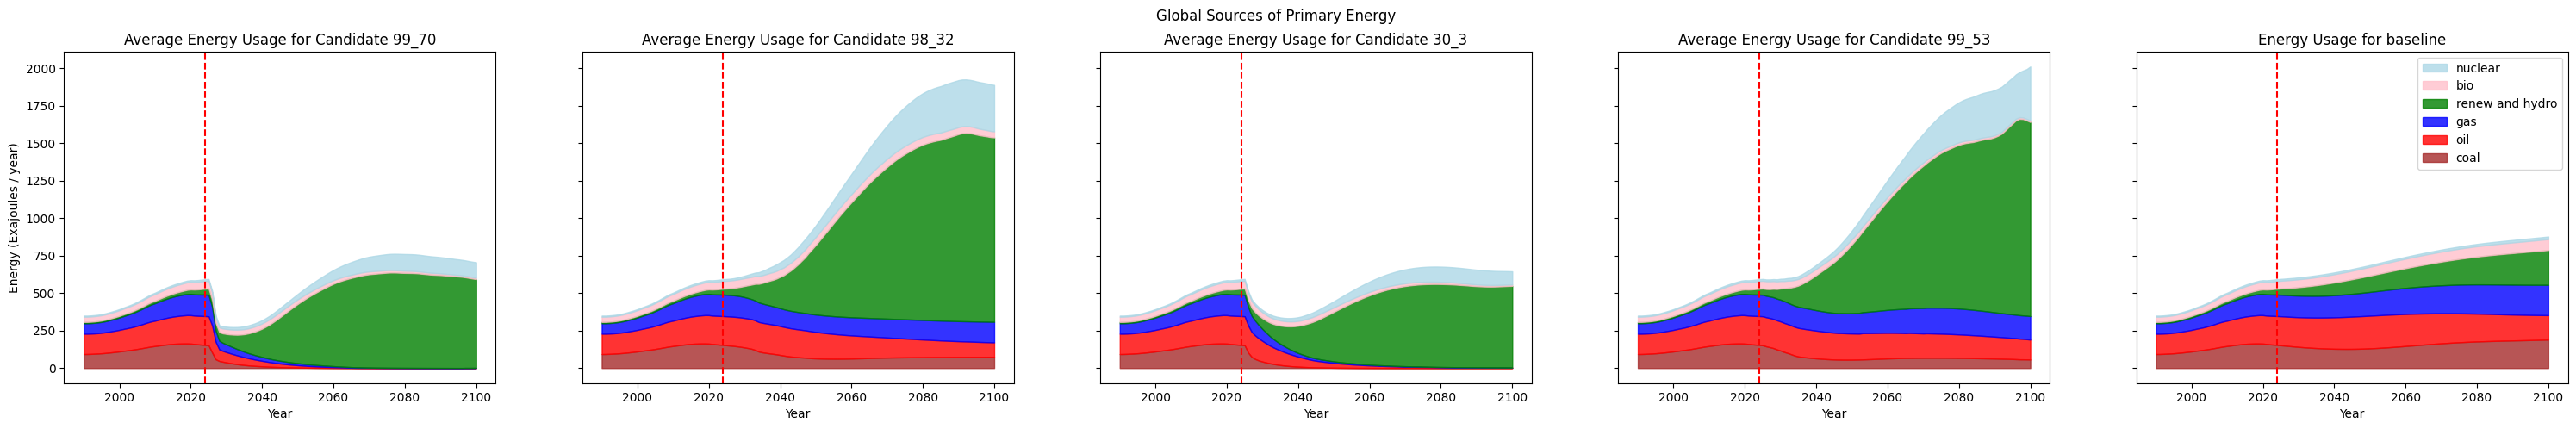

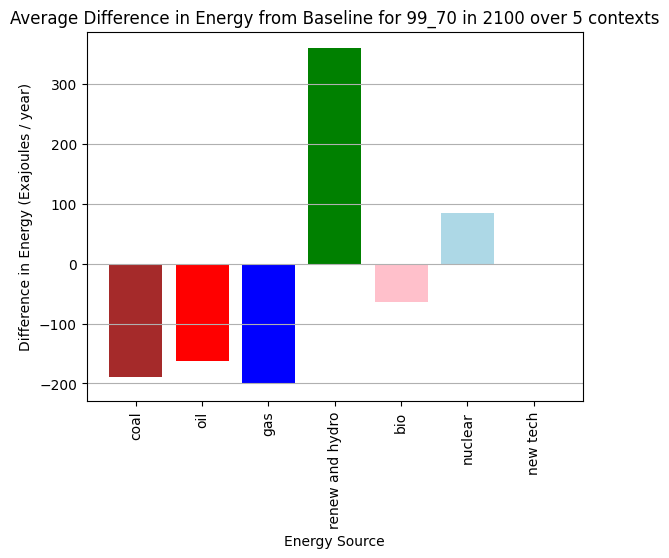

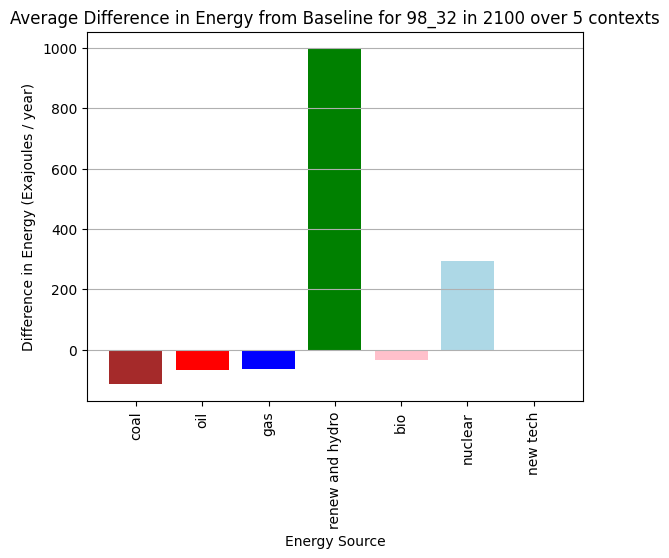

In [19]:
examples = best_cand_ids
plot_energy_usage(examples +  ["baseline"])
plot_energy_difference(examples[0])
plot_energy_difference(examples[1])

In [ ]:
# Uncomment to open the browser for each example
# for example in examples:
#     open_browser(results_dir, example, 0)

Bad pipe message: %s [b"\xe42\x90\x0bx\xf2'\xb3E\xf7\x99\x04\x89`\xd5\t\x03\x08\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x00", b'2\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00']
Bad pipe message: %s [b'k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t']
Bad pipe message: %s [b'k\xafj\xbe\xb9\x19u\xa6s\xef\xcfI\\[\xf6\x94\x1d\x84\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x0